In [1]:
import os, sys, pandas as pd, wfdb, pickle, scipy, time
from datetime import datetime, timedelta
import matplotlib.pyplot as plt, librosa
from scipy.signal import spectrogram
from scipy import interpolate
import torch, torchvision, torch.nn as nn
import numpy as np, librosa
from torch.utils.data import Dataset, DataLoader, ConcatDataset, sampler, WeightedRandomSampler
import torch.optim as optim
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
import numba
import tqdm.notebook as n_tqdm
import random
from IPython.display import Audio
from torchsummary import summary
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from torch.utils.data.sampler import SubsetRandomSampler
import concurrent.futures
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import torchvision
import torchsummary
from numba import njit
import torchvision.models as models
from torchsummary import summary

ModuleNotFoundError: No module named 'torchsummary'

In [14]:
base_dir = '/N/project/waveform_mortality/rmahawar/waveform'

In [15]:
sys.path = [base_dir] + sys.path

In [2]:
from utils.data_utils import *

ModuleNotFoundError: No module named 'utils'

In [17]:
### Config
n_folds = 3
classes = 2
X = 10
Y = 72
workers = 64
modality = ['II']
batch_size = 8

In [18]:
test = pd.read_csv(os.path.join(base_dir, 'db', 'MV_Mortality.csv'))
test.head()

,SUBJECT_ID,INTIME,OUTTIME,VStart,VEndtime,deathtime,DEATH_T0,DEATH_MV
0,543,2148-12-13 19:41:49.000000 UTC,2148-12-17 19:45:40.000000 UTC,2148-12-13 22:00:00.000000 UTC,2148-12-15 08:00:00.000000 UTC,NaN,999999,999999
1,1049,2118-09-04 14:22:40.000000 UTC,2118-09-10 12:42:22.000000 UTC,2118-09-04 20:00:00.000000 UTC,2118-09-09 07:00:00.000000 UTC,2118-09-10 11:25:00.000000 UTC,141,135
2,1501,2146-12-11 14:05:45.000000 UTC,2146-12-19 15:18:01.000000 UTC,2146-12-15 20:20:00.000000 UTC,2146-12-16 12:04:00.000000 UTC,NaN,999999,999999
3,2187,2134-06-30 23:21:18.000000 UTC,2134-07-02 17:52:28.000000 UTC,2134-07-02 14:15:00.000000 UTC,2134-07-02 15:00:00.000000 UTC,NaN,999999,999999
4,1855,2124-05-19 08:12:58.000000 UTC,2124-05-21 10:02:57.000000 UTC,2124-05-19 21:00:00.000000 UTC,2124-05-21 00:15:00.000000 UTC,2124-05-21 05:00:00.000000 UTC,45,32


In [7]:
len(test)

5003

In [8]:
### Build Model for a given x and Multiple Y [1, 2, ...12]
### Z is where the Mechanical Ventillation Starts
### X currently is 30 secs

### We are just using 1 modality. This will for sure give us less patients. 
### 2nd exp: Consider all ECG leads as same modality.


## X= 30 pateints= 83
## X= 300 pateints= 79
## X= 1800 i.e 30 mins pateints= 62

In [9]:
class Data:
    def __init__(self, table, x, y, z = 'VStart', modality = ['II'], num_workers = 64):
        super(Data, self).__init__()
        self.x = x
        self.z = z
        self.y = y
        self.modality = modality
        self.num_workers = num_workers
        self.table = pd.read_csv(table)
        self.table = create_snapshot(self.table, 0, self.y, 'DEATH_MV')
        self.selected_table = None
    
    def get_table(self):
        return self.table
    
    def get_selected_table(self):
        return self.selected_table
    
    def select_patients(self, threshold = 0.5):
        self.selected_table = self.select_patients_fast(self.table, threshold)

    def select_patients_fast(self, table, threshold = 0.5):
        df = table
        selected = [] 

        def process_row(i):
            pid = df.loc[i]['SUBJECT_ID']
            # start = datetime.strptime(df.loc[i]['INTIME'], '%Y-%m-%d %H:%M:%S.%f %Z')
            # end = start + timedelta(hours= self.z)
            # start = end - timedelta(seconds= self.x)

            icutime = datetime.strptime(df.loc[i]['INTIME'], '%Y-%m-%d %H:%M:%S.%f %Z')
            mvtime = datetime.strptime(df.loc[i]['VStart'], '%Y-%m-%d %H:%M:%S.%f %Z')

            # patient doesn't have enough waveform data to be analyzed
            if mvtime < icutime or (mvtime - icutime).total_seconds() < self.x:
                return None

            end = datetime.strptime(df.loc[i]['VStart'], '%Y-%m-%d %H:%M:%S.%f %Z')
            start = end - timedelta(seconds= self.x)

            # get data availability stats
            availability = get_waveform_availability(pid, (start, end), channels= self.modality)
            # remove patients if availability < 50%
            if availability[0] < threshold:
                return None 
            
            data = get_waveform_data(int(pid), (start, end), channels= self.modality)
            nans = np.isnan(data[0]).sum()/len(data[0]) if data is not None else -1
            
            if nans < threshold:
                return pid
            

            return None

        def run(f, data):
            l = len(data)
            results= []
            with n_tqdm.tqdm(total=l) as pbar:
                with concurrent.futures.ThreadPoolExecutor(max_workers= self.num_workers) as executor:
                    futures = {executor.submit(f, arg): arg for arg in range(l)}
                    for future in concurrent.futures.as_completed(futures):
                        arg = futures[future]
                        results.append(future.result())
                        pbar.update(1)
            return results
        
        results = run(process_row, df)
        selected = df[df['SUBJECT_ID'].isin([pid for pid in results if pid is not None])].reset_index(drop= True)
        return selected

In [23]:
data = Data(os.path.join(base_dir, 'db', 'MV_Mortality.csv'), x= X, y = Y, num_workers= workers, modality= modality)
data.select_patients(threshold= 0.5)

  0%|          | 0/4995 [00:00<?, ?it/s]

In [24]:
table = data.get_table()
len(table[table['label'] == 1]), len(table)

(517, 4995)

In [25]:
selected_table = data.get_selected_table()
create_splits(selected_table, n_folds)
selected_table.to_csv(f'../db/selected_x{X}_y{Y}.csv')

#### Train

In [19]:
selected_table = pd.read_csv(os.path.abspath(f'../db/selected_x{X}_y{Y}.csv'))

In [20]:
len(selected_table[selected_table['label']== 1]), len(selected_table[selected_table['label']== 0])

(195, 1439)

In [21]:
len(selected_table)

1634

In [22]:
train_df, test_df = get_fold_split(selected_table, 0)

In [95]:
class ECG_Data(Dataset):
    def __init__(self, table, x, y, z = 'VStart', modality = ['II']):
        super(ECG_Data, self).__init__()
        self.table = table
        self.x = x
        self.y = y 
        self.z = z
        self.modality = modality

        class_labels = table['label'].values
        class_counts = np.bincount(class_labels)
        class_weights = 1.0 / class_counts

        # Use class weights to create the WeightedRandomSampler
        self.samples_weights = [class_weights[label] for label in class_labels]
        self.sampler = WeightedRandomSampler(weights= self.samples_weights, num_samples= len(table), replacement=True)

    def __len__(self):
        return len(self.table)

    def get_table(self):
        return self.table

    def transform(self):
        return transforms.Compose([
                # transforms.ToTensor(),  # Convert to a PyTorch tensor #problematic becuase spectograms are not in range (0, 255)
                # transforms.Lambda(lambda x: np.log(x + 1e-8)),
                transforms.Lambda(lambda x: torch.tensor((x - np.min(x))/(np.max(x) - np.min(x) + 1e-8)).unsqueeze(0))
            ])
    
    def get_sample_weights(self):
        return self.samples_weights

    def preprocess(self, sig):

        lowpassed = scipy.signal.medfilt(sig, kernel_size= 125)
        highpassed = sig - lowpassed

        # High Frequency removal
        lowpass = scipy.signal.butter(1, 10, btype='lowpass', fs= 125, output='sos')
        lowpassed = scipy.signal.sosfilt(lowpass, highpassed)

        sig = lowpassed
        # sig = highpassed
        f, t, sig = scipy.signal.stft(sig, nperseg = 125, noverlap = 70)
        sig = np.abs(sig)
        # sig = sig[:30, :]
        sig = self.transform()(sig)
        return sig

    def __getitem__(self, idx):
        chart = self.table
        patient_id = chart.loc[idx]['SUBJECT_ID']
        # start = datetime.strptime(chart.loc[idx]['INTIME'], '%Y-%m-%d %H:%M:%S.%f %Z')
        # end = start + timedelta(hours= self.z)
        # start = end - timedelta(seconds= self.x)

        end = datetime.strptime(chart.loc[idx]['VStart'], '%Y-%m-%d %H:%M:%S.%f %Z')
        start = end - timedelta(seconds= self.x)

        data = get_waveform_data(int(patient_id), (start, end), channels= self.modality)

        # missing value aware training
        data[np.isnan(data)] = 0.0
        # missing = ~(np.isnan(data))
        # data = np.concatenate([data, missing])
        # print(f'E: {np.max(data)}')
        # data = borrow(data[0, :])
        # print(f'X: {np.max(data)}')
        data = self.preprocess(data[0])
        # if torch.sum(data) == 0:
        #     print(f'{patient_id}: has all 0 data')
        label = chart.loc[idx]['label']
        return data, label

In [96]:
train_dataset = ECG_Data(train_df, x= X, y = Y, modality= modality)
test_dataset = ECG_Data(test_df, x= X, y = Y, modality= modality)

In [97]:
len(test_dataset), len(train_dataset)

(545, 1089)

In [98]:
train_loader = DataLoader(train_dataset, batch_size= 64, sampler= train_dataset.sampler, num_workers= workers, pin_memory= True, drop_last= True)
test_loader = DataLoader(test_dataset, batch_size= 545, shuffle= False, num_workers= 1, pin_memory= True)

In [30]:
for x, y in tqdm.tqdm(train_loader):
    # print(torch.min(x), torch.max(x))
    pass

100%|██████████| 136/136 [00:06<00:00, 20.64it/s]


In [84]:
next(iter(train_loader))[0].shape

torch.Size([64, 1, 1250])

In [23]:
for x,_ in tqdm.tqdm(test_loader):
    print(torch.min(x), torch.max(x))

100%|██████████| 1/1 [02:10<00:00, 130.50s/it]

tensor(0., dtype=torch.float64) tensor(1.0000, dtype=torch.float64)


In [99]:
def train(model, train_loader, test_loader, criteria, lr = 1e-3, weight_decay = 1e-4, max_epochs = 50, device = 'cuda', name = 'nn_model.pth'):

    train_loss = np.zeros(max_epochs )
    val_loss = np.zeros(max_epochs )
    val_acc = np.zeros(max_epochs)
    val_auc = np.zeros(max_epochs)

    criterion = criteria
    optimizer = optim.AdamW(model.parameters(), lr, weight_decay= weight_decay)
    # scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [10], gamma= 0.1)
    model = model.to(device)
    t = tqdm.trange(max_epochs, desc= 'Starting ...', leave= True)
    
    best_auc = 0.5
    val_auc_patience = 10
    current_lr  = lr
    patience = 0

    for epoch in t:
        model.train(True)
        t_loss = 0
        total = 0
        for x, y in train_loader:
            x= x.to(device)
            y= y.to(device)

            outputs = model(x)
            # print(outputs)
            
            loss = criterion(outputs, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            t_loss += loss.item()
            total += 1
        
        # break
        # scheduler.step()
        # print(len(train_loss))
        train_loss[epoch] = t_loss
        
        model.eval()

        with torch.no_grad():
            v_loss = 0
            total = 0
            y_true = np.zeros(test_loader.batch_size * len(test_loader))
            y_pred = np.zeros(test_loader.batch_size * len(test_loader))
            for x, y in test_loader:
                x= x.to(device)
                y= y.to(device)
                y_hat = model(x)
                pred = torch.argmax(y_hat, dim= 1)
                y_pred[total*test_loader.batch_size: total*test_loader.batch_size + test_loader.batch_size] = pred.cpu().detach().numpy()
                y_true[total*test_loader.batch_size: total*test_loader.batch_size + test_loader.batch_size] = y.cpu().detach().numpy()
                v_loss += criterion(y_hat, y).item()
                total += 1

        val_loss[epoch] = v_loss
        val_acc[epoch] = 100* np.sum(y_true == y_pred)/len(y_true)
        val_auc[epoch] = roc_auc_score(y_true, y_pred)

        t.set_description(f'{epoch}/{max_epochs}: Train:Loss = {train_loss[epoch]}, Val:Loss = {val_loss[epoch]}, Val:AUC = {val_auc[epoch]}', refresh= True)

        # if val_auc[epoch] > best_auc:
        #     best_auc = val_auc[epoch]
        #     patience = 0
        # else:
        #     patience += 1
        #     if patience == val_auc_patience/2:
        #         current_lr *= 0.1
        #         for param_group in optimizer.param_groups:
        #             param_group['lr'] = current_lr
        #     if patience == val_auc_patience:
        #         break
    # print(scheduler.get_lr())
    return train_loss, val_loss, val_acc, val_auc

In [86]:
torch.autograd.set_detect_anomaly(True)

In [87]:
class RonNet1D(nn.Module):
    def __init__(self):
        super(RonNet1D, self).__init__()

        self.model = nn.Sequential()
        # Convolutional layers'
        self.model.append(nn.BatchNorm1d(1))
        self.model.append(nn.Conv1d(1, 64, kernel_size= 5,))
        self.model.append(nn.BatchNorm1d(64))
        self.model.append(nn.ReLU())
        self.model.append(nn.MaxPool1d(kernel_size= 2, stride= 2))
        # self.dropout1 = nn.Dropout2d(p=0.25)

        self.model.append(nn.Conv1d(64, 128, kernel_size= 3, padding= 1))
        self.model.append(nn.BatchNorm1d(128))
        self.model.append(nn.ReLU())
        self.model.append(nn.MaxPool1d(kernel_size= 2, stride= 2))
        # # self.dropout2 = nn.Dropout2d(p=0.25)

        self.model.append(nn.Conv1d(128, 256, kernel_size= 3, padding= 1))
        self.model.append(nn.BatchNorm1d(256))
        self.model.append(nn.ReLU())
        self.model.append(nn.MaxPool1d(kernel_size= 2, stride= 2))

        # Fully connected layers
        self.model.append(nn.AdaptiveAvgPool1d(1))
        self.fc1 = nn.Linear(256, 2)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(1024, 2)  # Assuming input size of 64x64

        for layer in self.model.children():
            if isinstance(layer, (nn.Conv2d, nn.Linear)):
                nn.init.kaiming_normal_(layer.weight, nonlinearity= 'relu')

    def forward(self, x):
        x = x.float()
        x = self.model(x)
        x = torch.flatten(x, 1)
        # print(x.shape)   
        # x = self.act(self.fc1(x))
        x = self.fc1(x)
        return x

In [110]:
class RonNet2D(nn.Module):
    def __init__(self):
        super(RonNet2D, self).__init__()

        self.model = models.resnet18(pretrained = False)
        self.model.conv1 = nn.Conv2d(1, 64, 5, 2, 3, bias= False)
        self.model.fc = nn.Linear(512, 2)

        # self.model = nn.Sequential()
        # # Convolutional layers
        # self.model.append(nn.Conv2d(1, 64, kernel_size= 5, padding= 2))
        # self.model.append(nn.BatchNorm2d(64))
        # self.model.append(nn.ReLU())
        # self.model.append(nn.MaxPool2d(kernel_size= 2, stride= 2))
        # # self.dropout1 = nn.Dropout2d(p=0.25)

        # self.model.append(nn.Conv2d(64, 128, kernel_size= 3, padding= 1))
        # self.model.append(nn.BatchNorm2d(128))
        # self.model.append(nn.ReLU())
        # self.model.append(nn.MaxPool2d(kernel_size= 2, stride= 2))
        # # self.dropout2 = nn.Dropout2d(p=0.25)

        # self.model.append(nn.Conv2d(128, 256, kernel_size= 3, padding= 1))
        # self.model.append(nn.BatchNorm2d(256))
        # self.model.append(nn.ReLU())
        # self.model.append(nn.MaxPool2d(kernel_size= 2, stride= 2))

        # # Fully connected layers
        # self.model.append(nn.AdaptiveAvgPool2d(1))
        # self.fc1 = nn.Linear(256, 2)
        # self.act = nn.ReLU()
        # self.fc2 = nn.Linear(128, 2)  # Assuming input size of 64x64

        # for layer in self.model.children():
        #     if isinstance(layer, (nn.Conv2d, nn.Linear)):
        #         nn.init.kaiming_normal_(layer.weight, nonlinearity= 'relu')

    def forward(self, x):
        x = x.float()
        x = self.model(x)
        # x = torch.flatten(x, 1)
        # # print(x.shape)   
        # x = self.act(self.fc1(x))
        # x = self .fc2(x)
        return x

In [111]:
model = RonNet2D()

In [112]:
model

RonNet2D(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [113]:
summary(model.to('cuda'), input_size= (1, 100, 100), batch_size= 1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 64, 51, 51]           1,600
       BatchNorm2d-2            [1, 64, 51, 51]             128
              ReLU-3            [1, 64, 51, 51]               0
         MaxPool2d-4            [1, 64, 26, 26]               0
            Conv2d-5            [1, 64, 26, 26]          36,864
       BatchNorm2d-6            [1, 64, 26, 26]             128
              ReLU-7            [1, 64, 26, 26]               0
            Conv2d-8            [1, 64, 26, 26]          36,864
       BatchNorm2d-9            [1, 64, 26, 26]             128
             ReLU-10            [1, 64, 26, 26]               0
       BasicBlock-11            [1, 64, 26, 26]               0
           Conv2d-12            [1, 64, 26, 26]          36,864
      BatchNorm2d-13            [1, 64, 26, 26]             128
             ReLU-14            [1, 64,

In [114]:
#### Tried 1-D CNN with just 1 layer, with 3 layers, Tried ResNet18, Tried custom 2-D CNN models, 

In [115]:
train_loss, val_loss, val_acc, val_auc = train(model, train_loader, test_loader, criteria= nn.CrossEntropyLoss())

33/50: Train:Loss = 0.6202926434925757, Val:Loss = 1.2108354568481445, Val:AUC = 0.5109775641025641:  68%|██████▊   | 34/50 [05:04<02:23,  8.94s/it] Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5f1c3c4280>
Traceback (most recent call last):
  File "/N/slate/rmahawar/anaconda3/envs/ronak/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/N/slate/rmahawar/anaconda3/envs/ronak/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/N/slate/rmahawar/anaconda3/envs/ronak/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Bad file descriptor (src/epoll.cpp:100)
33/50: Train:Loss = 0.6202926434925757, Val:Loss = 1.2108354568481445, Val:AUC = 0.5109775641025641:  68%|██████▊   | 34/50 [05:1

RuntimeError: DataLoader worker (pid(s) 90475) exited unexpectedly

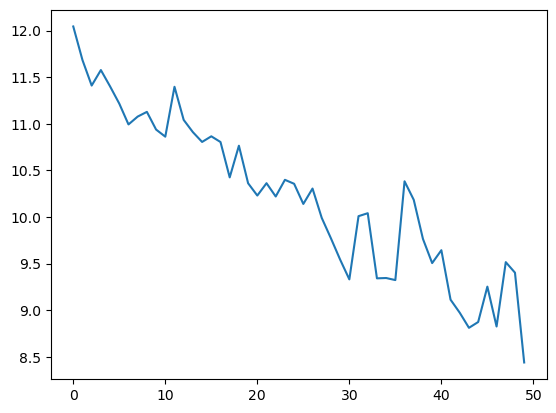

In [93]:
plt.plot(train_loss)

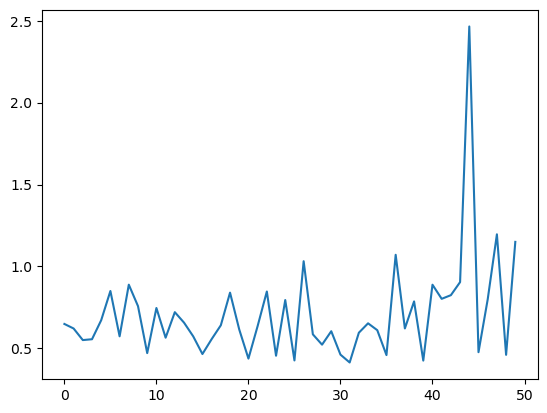

In [94]:
plt.plot(val_loss)

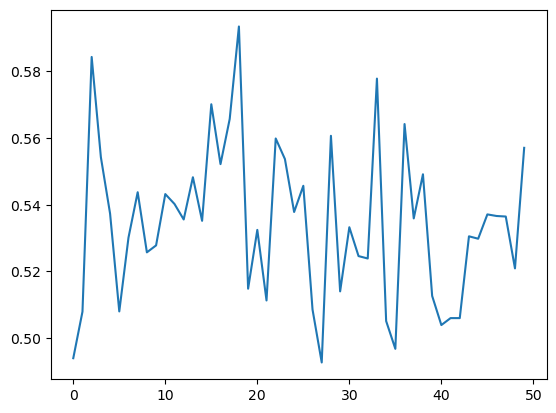

In [61]:
plt.plot(val_auc)

In [225]:
train_loss, val_loss, val_acc, val_auc = train(model, train_loader, test_loader, criteria= nn.CrossEntropyLoss())

21/50: Train:Loss = 0.18411535024642944, Val:Loss = 0.34684136509895325, Val:AUC = 0.5468308287457223:  42%|████▏     | 21/50 [04:03<05:35, 11.58s/it]


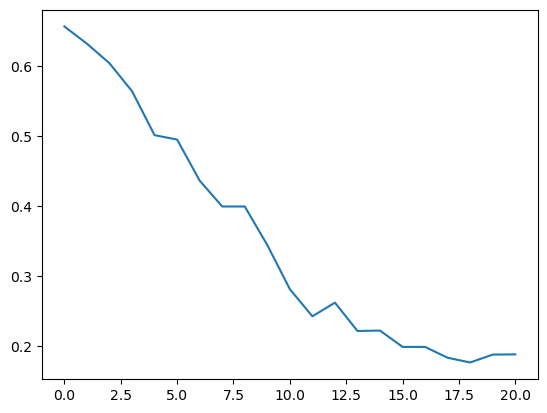

In [226]:
plt.plot(train_loss[:21])

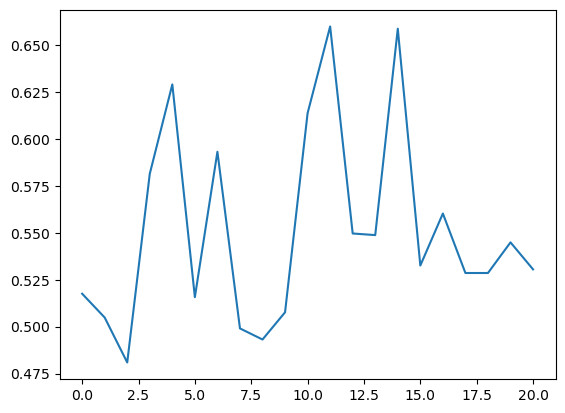

In [227]:
plt.plot(val_auc[:21])

In [ ]:
auc= []
train_loss = []
val_loss = []

for fold in range(n_folds):
    train_dir = f'folds/train_{fold}.csv'
    val_dir = f'folds/val_{fold}.csv'

    train_data = ECG_Data(table= train_dir, x= 30, z= 6, num_workers= 128)
    val_data = ECG_Data(table= val_dir, x= 30, z= 6, num_workers= 64)

    labels = train_data.get_table()['label'].values.tolist()
    class_weights = torch.bincount(torch.tensor(labels)).float()
    weights = 1.0 / class_weights[labels]
    sampler = sampler.WeightedRandomSampler(weights, len(weights))

    train_loader = DataLoader(train_data, batch_size= 64, num_workers= 32, pin_memory= True, sampler= sampler)
    val_loader = DataLoader(val_data, batch_size= 32, num_workers= 32)

    model = torchvision.models.resnet18(pretrained= False)
    model.fc = nn.Linear(model.fc.in_features, classes)
    
    print(torchsummary(model, ()))
    
    

#### How many new patients will V lead ECG add to the existing set of II lead ECG Patients? Turns out only 4 new patients when y = 24. Hence, Contrastive Learning is not worth it!

In [ ]:
II_patients = selected_table['SUBJECT_ID'].values

In [ ]:
V_patients = selected_table['SUBJECT_ID'].values

In [ ]:
x = np.intersect1d(II_patients, V_patients)

In [ ]:
len(x), len(V_patients), len(II_patients)

(952, 996, 1680)

In [ ]:
y = np.setdiff1d(V_patients, II_patients)

In [ ]:
len(y)

44

In [ ]:
test_df = table[table['SUBJECT_ID'].isin(y)]

In [ ]:
test_df['label'].sum()

4

In [ ]:
# V -> 60, II -> 83, 
len(selected_table[selected_table['label'] == 1]), 

(60,)